In [1]:
import keras

Using TensorFlow backend.


In [2]:
keras.__version__

'2.2.4'

# 1. 로이터 데이터 가져오기

In [3]:
from keras.datasets import reuters

In [4]:
dir(reuters)

['__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_remove_long_seq',
 'absolute_import',
 'division',
 'get_file',
 'get_word_index',
 'json',
 'load_data',
 'np',
 'print_function',
 'warnings']

##  pickle 처리 오류 


 - ValueError: Object arrays cannot be loaded when allow_pickle=False
 
 - nympy 버전을 1.16.3 이하로 유지하고 np.load 함수를 람다함수로 수정해서 처리해야 함

In [5]:
import numpy as np

In [6]:
old = np.load
np.load = lambda *a,**k: old(*a,**k,allow_pickle=True)

In [7]:
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

In [8]:
np.load = old

## 다차원 배열 내의 원소가 리스트

In [9]:
train_data.shape

(8982,)

In [10]:
type(train_data[0])

list

In [11]:
train_labels.shape

(8982,)

In [12]:
type(train_labels)

numpy.ndarray

In [13]:
train_labels[0]

3

## 실제 데이터 정보 확인하기

- 영어 단어들이 어떤 인덱스로 구성된 지를 확인한다

In [14]:
word = reuters.get_word_index()

In [15]:
type(dict)

type

In [16]:
len(word)

30979

In [17]:
[*word.keys()][:3]

['mdbl', 'fawc', 'degussa']

###  내부의 키와 값을 스와핑하기

In [18]:
reverse_word = [(v,k) for k,v in word.items()]

In [19]:
reverse_word[:3]

[(10996, 'mdbl'), (16260, 'fawc'), (12089, 'degussa')]

In [20]:
reverse_word = dict(reverse_word)

In [21]:
type(reverse_word)

dict

In [22]:
[*reverse_word.items()][:3]

[(10996, 'mdbl'), (16260, 'fawc'), (12089, 'degussa')]

## 판다스로 변환할 때 에러 발생

- index=[0] 으로 인자를 전달할 것 

In [23]:
import pandas as pd

In [24]:
df_words = pd.DataFrame(word, index = [0])

In [25]:
df_words.head()

,mdbl,fawc,degussa,woods,hanging,localized,sation,chanthaburi,refunding,hermann,...,withstood,illegally,june,jung,may's,rotting,pods,emery,northerly,onomichi
0,10996,16260,12089,8803,13796,20672,20673,20675,10997,8804,...,30961,8469,249,30978,10065,16258,10995,2849,30979,16259


In [26]:
df_words_un = df_words.unstack()

In [27]:
df_words_un.head()

mdbl     0    10996
fawc     0    16260
degussa  0    12089
woods    0     8803
hanging  0    13796
dtype: int64

In [28]:
df_words_v = df_words_un.to_frame()

In [29]:
df_words_v = df_words_v.reset_index()

In [30]:
df_words_v.head()

,level_0,level_1,0
0,mdbl,0,10996
1,fawc,0,16260
2,degussa,0,12089
3,woods,0,8803
4,hanging,0,13796


In [31]:
df_words_v = df_words_v.drop(['level_1'], axis=1)

In [32]:
df_words_v.columns = ['words','index' ]

In [33]:
df_words_v.head()

,words,index
0,mdbl,10996
1,fawc,16260
2,degussa,12089
3,woods,8803
4,hanging,13796


In [34]:
df_words_v.shape

(30979, 2)

In [35]:
df_words_v['index'].value_counts().count()

30979

## 훈련 데이터를 영어로 변환해 보기

In [36]:
decoded_new = " ".join([reverse_word.get(i, '?') for i in train_data[0]])

In [37]:
decoded_new

'the of of mln loss for plc said at only ended said commonwealth could 1 traders now april 0 a after said from 1985 and from foreign 000 april 0 prices its account year a but in this mln home an states earlier and rise and revs vs 000 its 16 vs 000 a but 3 psbr oils several and shareholders and dividend vs 000 its all 4 vs 000 1 mln agreed largely april 0 are 2 states will billion total and against 000 pct dlrs'

### 0,1,2 인덱스에 있는 단어는 패딩, 문서시작, 사전에 없음을 보관하므로 3을 빼고 처리해야 함

In [38]:
decoded_news = " ".join([reverse_word.get(i-3,  '?') for i in train_data[0]])

In [39]:
decoded_news

'? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3'

# 2. 데이터 준비하기

In [40]:
def vectorize_sequence(sequences, dimension=10000) :
    results = np.zeros((len(sequences), dimension))
    print("zeros shape", results.shape)
    
    for i, seq  in enumerate(sequences) :
        results[i, seq] = 1.
    return results

## 훈련데이터를 변환

- 각 행이 리스트 데이터를 인덱스로 해서 1을 세팅 

In [41]:
train_data[0][:5]

[1, 2, 2, 8, 43]

In [42]:
x_train = vectorize_sequence(train_data)

zeros shape (8982, 10000)


In [43]:
x_train.shape

(8982, 10000)

In [44]:
x_train[0]

array([0., 1., 1., ..., 0., 0., 0.])

## 테스트 데이터 변환 

In [45]:
x_test = vectorize_sequence(test_data)

zeros shape (2246, 10000)


## 레이블 데이터 변환

In [46]:
from keras.utils.np_utils import to_categorical

### 레이블 데이터는 0부터 45까지 총 46개의 범주로 구성

In [53]:
tr = pd.Series(train_labels)

In [55]:
tr.value_counts().count()

46

In [49]:
train_labels[0]

3

### 1번 축을 46개로 확대

In [47]:
one_hot_train_labels = to_categorical(train_labels)

In [50]:
one_hot_train_labels[0]

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [51]:
one_hot_train_labels.shape

(8982, 46)

In [48]:
one_hot_test_labels = to_categorical(test_labels)

In [52]:
one_hot_test_labels.shape

(2246, 46)

# 3. 모델 구성

## 모델을 생성

In [57]:
from keras import models, layers

In [58]:
model = models.Sequential()

In [60]:
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))

Instructions for updating:
Colocations handled automatically by placer.


In [61]:
model.add(layers.Dense(64, activation='relu'))

In [62]:
model.add(layers.Dense(46, activation='softmax'))

## 모델 컴파일 하기

In [64]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

# 4. 훈련 검증

## 훈련과 검증 데이터 분리

In [65]:
x_val = x_train[:1000]

In [66]:
partial_x_train = x_train[1000:]

In [67]:
y_val = one_hot_train_labels[:1000]

In [68]:
partial_y_train = one_hot_train_labels[1000:]

## 에포크 20 으로 훈련하기

In [69]:
history = model.fit(partial_x_train, partial_y_train, epochs=20, batch_size=512, validation_data=(x_val, y_val))

Instructions for updating:
Use tf.cast instead.
Train on 7982 samples, validate on 1000 samples
Epoch 1/20
7982/7982 [==============================] - 1s 140us/step - loss: 2.5322 - acc: 0.4955 - val_loss: 1.7208 - val_acc: 0.6120
Epoch 2/20
7982/7982 [==============================] - 1s 83us/step - loss: 1.4452 - acc: 0.6879 - val_loss: 1.3459 - val_acc: 0.7060
Epoch 3/20
7982/7982 [==============================] - 1s 81us/step - loss: 1.0953 - acc: 0.7651 - val_loss: 1.1708 - val_acc: 0.7430
Epoch 4/20
7982/7982 [==============================] - 1s 83us/step - loss: 0.8697 - acc: 0.8165 - val_loss: 1.0793 - val_acc: 0.7590
Epoch 5/20
7982/7982 [==============================] - 1s 86us/step - loss: 0.7034 - acc: 0.8472 - val_loss: 0.9844 - val_acc: 0.7810
Epoch 6/20
7982/7982 [==============================] - 1s 81us/step - loss: 0.5667 - acc: 0.8802 - val_loss: 0.9411 - val_acc: 0.8040
Epoch 7/20
7982/7982 [==============================] - 1s 80us/step - loss: 0.4581 - acc: 0.

## 훈련 및 검증 손실 그리기

In [70]:
import matplotlib.pyplot as plt

In [71]:
%matplotlib inline

###  훈련 및 검증 데잍 확인하기

In [72]:
history

In [74]:
his_df = pd.DataFrame(history.history)

In [75]:
his_df.head()

,val_loss,val_acc,loss,acc
0,1.720810,0.612,2.532207,0.495490
1,1.345868,0.706,1.445201,0.687923
2,1.170758,0.743,1.095272,0.765096
3,1.079259,0.759,0.869666,0.816462
4,0.984387,0.781,0.703356,0.847156


### 9번 에포크 이후 과대적합 이 발생

Text(0, 0.5, 'loss')

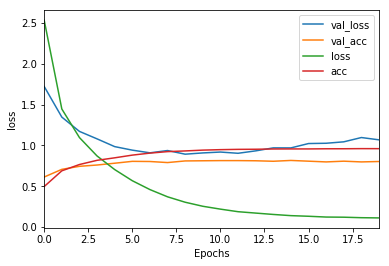

In [78]:
his_df.plot()
plt.xlabel('Epochs')
plt.ylabel('loss')

## 다시 9번만 에포크 처리

In [79]:
history1 = model.fit(partial_x_train, partial_y_train, epochs=9, batch_size=512, validation_data=(x_val, y_val))

Train on 7982 samples, validate on 1000 samples
Epoch 1/9
7982/7982 [==============================] - 1s 84us/step - loss: 0.1055 - acc: 0.9575 - val_loss: 1.1033 - val_acc: 0.7990
Epoch 2/9
7982/7982 [==============================] - 1s 82us/step - loss: 0.1019 - acc: 0.9579 - val_loss: 1.1133 - val_acc: 0.8020
Epoch 3/9
7982/7982 [==============================] - 1s 83us/step - loss: 0.1028 - acc: 0.9592 - val_loss: 1.0965 - val_acc: 0.7960
Epoch 4/9
7982/7982 [==============================] - 1s 79us/step - loss: 0.1030 - acc: 0.9575 - val_loss: 1.1221 - val_acc: 0.7970
Epoch 5/9
7982/7982 [==============================] - 1s 82us/step - loss: 0.0970 - acc: 0.9590 - val_loss: 1.1496 - val_acc: 0.8020
Epoch 6/9
7982/7982 [==============================] - 1s 82us/step - loss: 0.0988 - acc: 0.9565 - val_loss: 1.2267 - val_acc: 0.7870
Epoch 7/9
7982/7982 [==============================] - 1s 89us/step - loss: 0.0960 - acc: 0.9575 - val_loss: 1.1766 - val_acc: 0.7990
Epoch 8/9
7982

In [80]:
his_df9 = pd.DataFrame(history1.history)

Text(0, 0.5, 'loss')

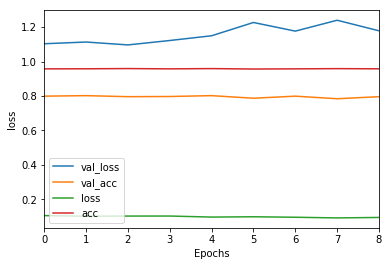

In [81]:
his_df9.plot()
plt.xlabel('Epochs')
plt.ylabel('loss')

In [82]:
results = model.evaluate(x_test, one_hot_test_labels)

2246/2246 [==============================] - 0s 74us/step


In [83]:
results

[1.3464759404597704, 0.7796081923950174]

# 5. 예측하기

In [84]:
predictions = model.predict(x_test)

In [88]:
predictions.shape

(2246, 46)

In [85]:
np.argmax(predictions[0])

3

In [87]:
np.argmax(one_hot_test_labels[0])

3

In [89]:
object.__subclasses__()

[type,
 weakref,
 weakcallableproxy,
 weakproxy,
 int,
 bytearray,
 bytes,
 list,
 NoneType,
 NotImplementedType,
 traceback,
 super,
 range,
 dict,
 dict_keys,
 dict_values,
 dict_items,
 odict_iterator,
 set,
 str,
 slice,
 staticmethod,
 complex,
 float,
 frozenset,
 property,
 managedbuffer,
 memoryview,
 tuple,
 enumerate,
 reversed,
 stderrprinter,
 code,
 frame,
 builtin_function_or_method,
 method,
 function,
 mappingproxy,
 generator,
 getset_descriptor,
 wrapper_descriptor,
 method-wrapper,
 ellipsis,
 member_descriptor,
 types.SimpleNamespace,
 PyCapsule,
 longrange_iterator,
 cell,
 instancemethod,
 classmethod_descriptor,
 method_descriptor,
 callable_iterator,
 iterator,
 coroutine,
 coroutine_wrapper,
 moduledef,
 module,
 EncodingMap,
 fieldnameiterator,
 formatteriterator,
 filter,
 map,
 zip,
 BaseException,
 hamt,
 hamt_array_node,
 hamt_bitmap_node,
 hamt_collision_node,
 keys,
 values,
 items,
 Context,
 ContextVar,
 Token,
 Token.MISSING,
 _frozen_importlib._Modul